In [87]:
import pandas as pd
import numpy as np

In [7]:
columns=['comments','date','color','size','plus','minuse','rate','name','brand']

In [9]:
df=pd.read_json('5044562.jl')

In [10]:
df=df.transpose().reset_index().drop('index', axis=1)

In [11]:
df=df.rename(columns={0:'comments',1:'date',2:'color',3:'size',4:'plus',5:'minuse',6:'rate',7:'name',8:'brand'})

In [13]:
df

,comments,date,color,size,plus,minuse,rate,name,brand
0,"Отличный пылесос, свою функцию выполняет , пыл...",2021-05-02T15:45:07Z,,0,1,0,5,Пылесос GL6256,GALAXY
1,Всасывает хорошо. Шнура достаточно. На фильтр ...,2021-05-02T13:47:36Z,,0,1,0,5,Пылесос GL6256,GALAXY
2,"Для этой цены, пылесос отличный. Очень лёгкий ...",2021-05-02T11:38:03Z,,0,2,0,5,Пылесос GL6256,GALAXY
3,Пылесос очень-очень хороший! Любимец мой! Втор...,2021-05-02T06:17:10Z,,0,2,0,5,Пылесос GL6256,GALAXY
4,Отличный за эту цену!!!!,2021-05-01T16:51:28Z,,0,1,0,5,Пылесос GL6256,GALAXY
...,...,...,...,...,...,...,...,...,...
3431,"Отличный пылесос, легко собирается.",2019-09-26T08:01:16.536772217Z,"голубой, белый",0,3,5,5,Пылесос GL6256,GALAXY
3432,ОЧЕНЬ УДОБНО И ХОРОШО,2019-11-20T12:46:21.171350589Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY
3433,"Удобный, лёгкий малыш. Тянен хорошо. За такие ...",2019-11-20T08:35:32.786532909Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY
3434,спасибо все отлично работает советую,2019-11-20T06:29:51.268463604Z,"голубой, белый",0,0,1,5,Пылесос GL6256,GALAXY


# РАЗБИВАЕМ ТЕКСТ НА ТОКЕНЫ

In [15]:
!pip install nltk

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
from nltk.tokenize import word_tokenize
text = df['comments']
df['comments_tok'] =[word_tokenize(i, language="russian") for i in text ]

In [19]:
df.loc[:0,'comments_tok']

0    [Отличный, пылесос, ,, свою, функцию, выполняе...
Name: comments_tok, dtype: object

# ИСКЛЮЧАЕМ СТОП-СЛОВА ИЗ ИСХОДНОГО ТЕКСТА,СТЕММИНГ: УДАЛЯЕМ ОКОНЧАНИЯ,ПРИВЕДЕНИЕ К НАЧАЛЬНОЙ ФОРМЕ С ЛЕММАТИЗАЦИЕЙ

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [376]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#import pymorphy2
stop_words = stopwords.words("russian")
stop_words.append('пылесос')
stop_words.append('очень')

snowball = SnowballStemmer(language="russian")
#morph = pymorphy2.MorphAnalyzer()

In [377]:

res=[]
for i in df['comments_tok']:
    filtered_tokens=[]
    for token in i:
        
        if token.lower() not in stop_words:
            filtered_tokens.append(token.lower())
          #  filtered_tokens.append(snowball.stem(token))
        #    filtered_tokens.append(morph.parse(snowball.stem(token)))
    res.append(filtered_tokens)        
df['filtered_tokens'] = res       

In [378]:
df

,comments,date,color,size,plus,minuse,rate,name,brand,comments_tok,filtered_tokens,filtered_tokens_str
0,"Отличный пылесос, свою функцию выполняет , пыл...",2021-05-02T15:45:07Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Отличный, пылесос, ,, свою, функцию, выполняе...","[отличный, ,, функцию, выполняет, ,, пылесосит...",", функцию выполняет , пылесосит . маленький , ..."
1,Всасывает хорошо. Шнура достаточно. На фильтр ...,2021-05-02T13:47:36Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Всасывает, хорошо, ., Шнура, достаточно, ., Н...","[всасывает, ., шнура, достаточно, ., фильтр, н...",всасывает . шнура достаточно . фильтр надела н...
2,"Для этой цены, пылесос отличный. Очень лёгкий ...",2021-05-02T11:38:03Z,,0,2,0,5,Пылесос GL6256,GALAXY,"[Для, этой, цены, ,, пылесос, отличный, ., Оче...","[цены, ,, отличный, ., лёгкий, обращении, ., м...","цены , . лёгкий обращении . мощный . единствен..."
3,Пылесос очень-очень хороший! Любимец мой! Втор...,2021-05-02T06:17:10Z,,0,2,0,5,Пылесос GL6256,GALAXY,"[Пылесос, очень-очень, хороший, !, Любимец, мо...","[очень-очень, хороший, !, любимец, !, второй, ...",очень-очень хороший ! любимец ! второй год пол...
4,Отличный за эту цену!!!!,2021-05-01T16:51:28Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Отличный, за, эту, цену, !, !, !, !]","[отличный, цену, !, !, !, !]",цену ! ! ! !
...,...,...,...,...,...,...,...,...,...,...,...,...
3431,"Отличный пылесос, легко собирается.",2019-09-26T08:01:16.536772217Z,"голубой, белый",0,3,5,5,Пылесос GL6256,GALAXY,"[Отличный, пылесос, ,, легко, собирается, .]","[отличный, ,, легко, собирается, .]",", легко собирается ."
3432,ОЧЕНЬ УДОБНО И ХОРОШО,2019-11-20T12:46:21.171350589Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY,"[ОЧЕНЬ, УДОБНО, И, ХОРОШО]",[удобно],удобно
3433,"Удобный, лёгкий малыш. Тянен хорошо. За такие ...",2019-11-20T08:35:32.786532909Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY,"[Удобный, ,, лёгкий, малыш, ., Тянен, хорошо, ...","[удобный, ,, лёгкий, малыш, ., тянен, ., такие...","удобный , лёгкий малыш . тянен . такие деньги ..."
3434,спасибо все отлично работает советую,2019-11-20T06:29:51.268463604Z,"голубой, белый",0,0,1,5,Пылесос GL6256,GALAXY,"[спасибо, все, отлично, работает, советую]","[спасибо, отлично, работает, советую]",спасибо отлично работает советую


In [339]:
df.loc[:0,'filtered_tokens']

0    [,, функцию, выполняет, ,, пылесосит, ., мален...
Name: filtered_tokens, dtype: object

# ОБУЧЕНИЕ МОДЕЛИ WORD2VEC

In [38]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    min_count=20,
    window=3,
    size=400,
    negative=20,
  # alpha=0.03,
   # min_alpha=0.0007,
   # sample=6e-5,
   # sg=1,
   workers=4
   )

Модель имеет множество аргументов:

min_count – игнорировать все слова с частотой встречаемости меньше, чем это значение.
windоw – размер контекстного окна,  обозначает диапазон контекста.
size – размер векторного представления слова (word embedding).
negative – сколько неконтекстных слов учитывать в обучении, используя negative sampling, 
alpha – начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).
min_alpha – минимальное значение learning_rate, на которое может опуститься в процессе обучения.
sg – если 1, то используется реализация 
Skip-gram; если 0, то CBOW.

In [39]:
w2v_model.build_vocab(df['filtered_tokens'])

In [40]:
w2v_model.train(df['filtered_tokens'], total_examples=len(df['filtered_tokens']), epochs=20, queue_factor=2)

(769684, 1595200)

# НАСКОЛЬКО ПОХОЖИ СЛОВА ОБУЧЕННОЙ МОДЕЛИ WORD2VEC

In [51]:
w2v_model.wv.most_similar(positive=["довол"])

[('рад', 0.8440830707550049),
 ('приобретен', 0.7893478274345398),
 ('довольн', 0.7586472630500793),
 ('нрав', 0.7429637908935547),
 ('рекоменд', 0.710296630859375),
 ('дешев', 0.6752406358718872),
 ('устраива', 0.6636437773704529),
 ('👍👍👍', 0.6541360020637512),
 ('к', 0.647106409072876),
 ('однозначн', 0.6439143419265747)]

# LDA

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [379]:
import re
def clean_and_lemmatize(text):
    #cleaning
    text = text.lower()
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r',',' ', text)
    text = re.sub(r'!',' ', text)
   # text = re.sub(r'.',' ', text)
   #text = re.sub(r'?',' ', text)
    #text = reg_tok.tokenize(text)
    
    
    # filtering
#    text = " ".join([word for word in text if not word in STOPWORDS and len(word) > 2])
    
    # lemmatization
 #   text = WordNetLemmatizer().lemmatize(text)
#    text = text.split()
    
    
    return text

In [380]:
df['filtered_tokens_str']=[' '.join(i) for i in df['filtered_tokens']]
df

,comments,date,color,size,plus,minuse,rate,name,brand,comments_tok,filtered_tokens,filtered_tokens_str
0,"Отличный пылесос, свою функцию выполняет , пыл...",2021-05-02T15:45:07Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Отличный, пылесос, ,, свою, функцию, выполняе...","[отличный, ,, функцию, выполняет, ,, пылесосит...","отличный , функцию выполняет , пылесосит . мал..."
1,Всасывает хорошо. Шнура достаточно. На фильтр ...,2021-05-02T13:47:36Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Всасывает, хорошо, ., Шнура, достаточно, ., Н...","[всасывает, ., шнура, достаточно, ., фильтр, н...",всасывает . шнура достаточно . фильтр надела н...
2,"Для этой цены, пылесос отличный. Очень лёгкий ...",2021-05-02T11:38:03Z,,0,2,0,5,Пылесос GL6256,GALAXY,"[Для, этой, цены, ,, пылесос, отличный, ., Оче...","[цены, ,, отличный, ., лёгкий, обращении, ., м...","цены , отличный . лёгкий обращении . мощный . ..."
3,Пылесос очень-очень хороший! Любимец мой! Втор...,2021-05-02T06:17:10Z,,0,2,0,5,Пылесос GL6256,GALAXY,"[Пылесос, очень-очень, хороший, !, Любимец, мо...","[очень-очень, хороший, !, любимец, !, второй, ...",очень-очень хороший ! любимец ! второй год пол...
4,Отличный за эту цену!!!!,2021-05-01T16:51:28Z,,0,1,0,5,Пылесос GL6256,GALAXY,"[Отличный, за, эту, цену, !, !, !, !]","[отличный, цену, !, !, !, !]",отличный цену ! ! ! !
...,...,...,...,...,...,...,...,...,...,...,...,...
3431,"Отличный пылесос, легко собирается.",2019-09-26T08:01:16.536772217Z,"голубой, белый",0,3,5,5,Пылесос GL6256,GALAXY,"[Отличный, пылесос, ,, легко, собирается, .]","[отличный, ,, легко, собирается, .]","отличный , легко собирается ."
3432,ОЧЕНЬ УДОБНО И ХОРОШО,2019-11-20T12:46:21.171350589Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY,"[ОЧЕНЬ, УДОБНО, И, ХОРОШО]",[удобно],удобно
3433,"Удобный, лёгкий малыш. Тянен хорошо. За такие ...",2019-11-20T08:35:32.786532909Z,"голубой, белый",0,1,1,5,Пылесос GL6256,GALAXY,"[Удобный, ,, лёгкий, малыш, ., Тянен, хорошо, ...","[удобный, ,, лёгкий, малыш, ., тянен, ., такие...","удобный , лёгкий малыш . тянен . такие деньги ..."
3434,спасибо все отлично работает советую,2019-11-20T06:29:51.268463604Z,"голубой, белый",0,0,1,5,Пылесос GL6256,GALAXY,"[спасибо, все, отлично, работает, советую]","[спасибо, отлично, работает, советую]",спасибо отлично работает советую


In [381]:
preprocessed_tweets = df['filtered_tokens_str'].apply(clean_and_lemmatize)
preprocessed_tweets

0       отличный   функцию выполняет   пылесосит . мал...
1       всасывает . шнура достаточно . фильтр надела н...
2       цены   отличный . лёгкий обращении . мощный . ...
3       очень-очень хороший   любимец   второй год пол...
4                                   отличный цену        
                              ...                        
3431                        отличный   легко собирается .
3432                                               удобно
3433    удобный   лёгкий малыш . тянен . такие деньги ...
3434                     спасибо отлично работает советую
3435    приобрела   . отличный помощник деньги . легки...
Name: filtered_tokens_str, Length: 3436, dtype: object

In [382]:
voc={}
count=0
for i in ((preprocessed_tweets)):
  for j in i.split(' '):
      
      if j not in voc:
          voc[j]=count
          count+=1
voc

{'отличный': 0,
 '': 1,
 'функцию': 2,
 'выполняет': 3,
 'пылесосит': 4,
 '.': 5,
 'маленький': 6,
 'маневренный': 7,
 'занимает': 8,
 'мало': 9,
 'места': 10,
 'покупке': 11,
 'рекомендую': 12,
 'всасывает': 13,
 'шнура': 14,
 'достаточно': 15,
 'фильтр': 16,
 'надела': 17,
 'носок': 18,
 'засорять': 19,
 'шумноват': 20,
 'свои': 21,
 'деньги': 22,
 '👍🏻': 23,
 'цены': 24,
 'лёгкий': 25,
 'обращении': 26,
 'мощный': 27,
 'единственное': 28,
 'колёсики': 29,
 'громко': 30,
 'катаются': 31,
 '(': 32,
 'особенно': 33,
 'ламинату': 34,
 ')': 35,
 'скейтборде': 36,
 'катаешься': 37,
 'очень-очень': 38,
 'хороший': 39,
 'любимец': 40,
 'второй': 41,
 'год': 42,
 'пользуюсь': 43,
 'двум': 44,
 'знакомым': 45,
 'рекомендовала.все': 46,
 'восторге': 47,
 'сын': 48,
 'машину': 49,
 'я-весь': 50,
 'дом': 51,
 'заказывайте.рекомендую': 52,
 'цену': 53,
 'чудес': 54,
 'ждите': 55,
 'убрать': 56,
 'локально': 57,
 'задача': 58,
 'остального': 59,
 'нужен': 60,
 'отлично': 61,
 'комточки': 62,
 'фини

In [383]:

count_vect = CountVectorizer(
                             
                             vocabulary=voc)

dataset = count_vect.fit_transform(df['filtered_tokens_str'])

In [384]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components = 60, max_iter=30, n_jobs=6, learning_method='batch', verbose=1)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=60, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [385]:
LDA(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=30, mean_change_tol=0.001,
             n_components=60, n_jobs=6,  perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=60, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [386]:
#Let\`s do simple interface class
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'
        
    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    def get_keywords(self, text, n_topics=5, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
        
        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])
        
        keywords = np.zeros(shape=(n_keywords*n_topics, self.lda.components_.shape[1]))
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [387]:
#text=''.join(df['filtered_tokens_str'])
text = ' '.join(df['comments'])
text

'Отличный пылесос, свою функцию выполняет , пылесосит очень хорошо. Маленький, маневренный,занимает мало места, к покупке рекомендую! Всасывает хорошо. Шнура достаточно. На фильтр надела носок , чтоб не засорять. Шумноват, но ничего. За свои деньги очень даже 👍🏻 Для этой цены, пылесос отличный. Очень лёгкий в обращении. Мощный. Единственное, колёсики громко катаются (особенно по ламинату), будто на скейтборде катаешься. Пылесос очень-очень хороший! Любимец мой! Второй год им пользуюсь. Двум знакомым его рекомендовала.все в восторге. Сын мой машину пылесосит,я-весь дом. Заказывайте.рекомендую! Отличный за эту цену!!!! Чудес не ждите ) убрать локально вот его задача, для всего остального нужен конечно другой более мощный пылесос. Все отлично. Всасывает даже комточки от фиников и маслин. С ним легко пылесосить. Пылесос отличный, работает супер, мощный. Очистил коврик в прихожей и в ванной, теперь как новые. Но пришел в разорванной коробке(( все детали на месте Хороший пылесос. Компактный.

In [388]:
tm = TopicModeler(count_vect, lda)

In [389]:
 #Let`s what words it will give us for the choosen text.
key_words = tm.get_keywords(text, n_topics=1, n_keywords=6)
print(key_words)

['коробка', 'работает', 'всё', 'отлично', 'целая', 'пришёл']


In [390]:
term_doc_matrix = count_vect.transform(df['filtered_tokens_str'])
embeddings = lda.transform(term_doc_matrix)

In [391]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans

In [392]:
kmeans = KMeans(n_clusters=5)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

In [393]:
embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [394]:
from matplotlib import cm as cm
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

In [395]:
count=0
for i in range(len(clust_labels)):
    if clust_labels[i]==3:
        print(df['comments'][i])
 

Заказала пылесос Забрала 28 апреля Коробка разорвана,облекаяна скотчем и сзади может вывалиться Ну это ладно Нету ручки и что мне делать ч этим полупылесосом Очень разочарована А вернуть нельзя я так понимаю
Жаль, что на коробке нет защитных пломб. Открыл - и бери, что хочешь. Мне пришёл полный комплект, всё отлично работает, я довольна покупкой!
Работает отлично.
Товар пришёл быстро. Коробка разорвана. Все в комплекте. Пылесос работает нормально. Товаром доволен.
Все хорошо. Пылесос работает
Лёгкий, мощный, удобный в использовании. Коробка была открыта и порвана, что смутило. Но комплектация соответствует заявленной в инструкции, которая на русском языке. Удобная техника для дома.
За такую сумму, такая мощь. Товар пришел вовремя, целый, работает всё. Я довольна!
Упаковано хорошо,все целое, работает здорово. Правда пыль столбом😏и шумноват.
Работает хорошо, мощный. Пока работает без нареканий.
Пришло в порваной коробке
Работает только от сети, а не как на фото и коробке. 
Про шнур ни сл

In [396]:
import matplotlib.pyplot as plt


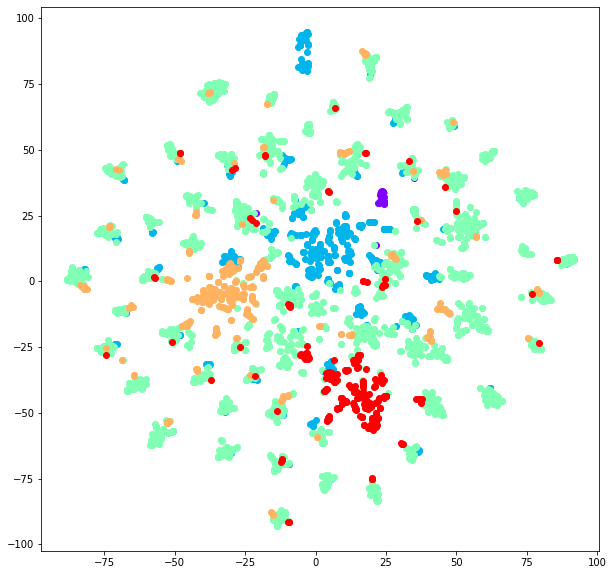

In [397]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()